In [1441]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

clusters = {
    "status" : ["Pclass", "Fare", "HasCabinRegistered"],
    "embarked" : ["Embarked_C", "Embarked_Q", "Embarked_S", "Embarked_null"]
}

def heatmap(df, figsize=(20, 12), method="spearman"):
    corr_matrix = df.select(
        pl.col(pl.selectors.NUMERIC_DTYPES)
    ).to_pandas().corr(method=method)

    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

pl.Config(tbl_rows=40, tbl_cols=1000)

df = pl.read_csv("../Data/Titanic/train.csv")

In [1442]:
df = df.with_columns(
    (pl.col("SibSp") + pl.col("Parch") + 1).alias("FamilySize"),
    pl.when(pl.col("Cabin").is_not_null()).then(1).otherwise(0).alias("HasCabinRegistered"),
    pl.when(pl.col("Age") < 16).then(1).otherwise(0).alias("IsChild")
).to_dummies(["Sex", "Embarked"], drop_first=False)

df = df.with_columns(
    pl.when((pl.col("FamilySize") >= 2) & (pl.col("FamilySize") <= 4)).then(1).otherwise(0).alias("HasSmallFamily")
)

df = df.drop("Sex_male", "SibSp", "Parch", "FamilySize", "Embarked_Q", "Embarked_S", "Embarked_null")

fare_mean, fare_std = df["Fare"].mean(), df["Fare"].std()
age_mean, age_std = df["Age"].mean(), df["Age"].std()

df = df.with_columns(
    ((pl.col("Fare") - fare_mean) / fare_std).alias("Fare"),
    ((pl.col("Age") - age_mean) / age_std).alias("Age")
)

pca = PCA()
pca_result = pca.fit_transform(df.select(clusters["status"]))

df = df.with_columns(
    pl.lit(pca_result[:, 0]).alias("Status_PC1"),
    pl.lit(pca_result[:, 1]).alias("Status_PC2"),
    # pl.lit(pca_result[:, 2]).alias("Status_PC3")
)
df = df.drop(clusters["status"])
df = df.drop("Age")

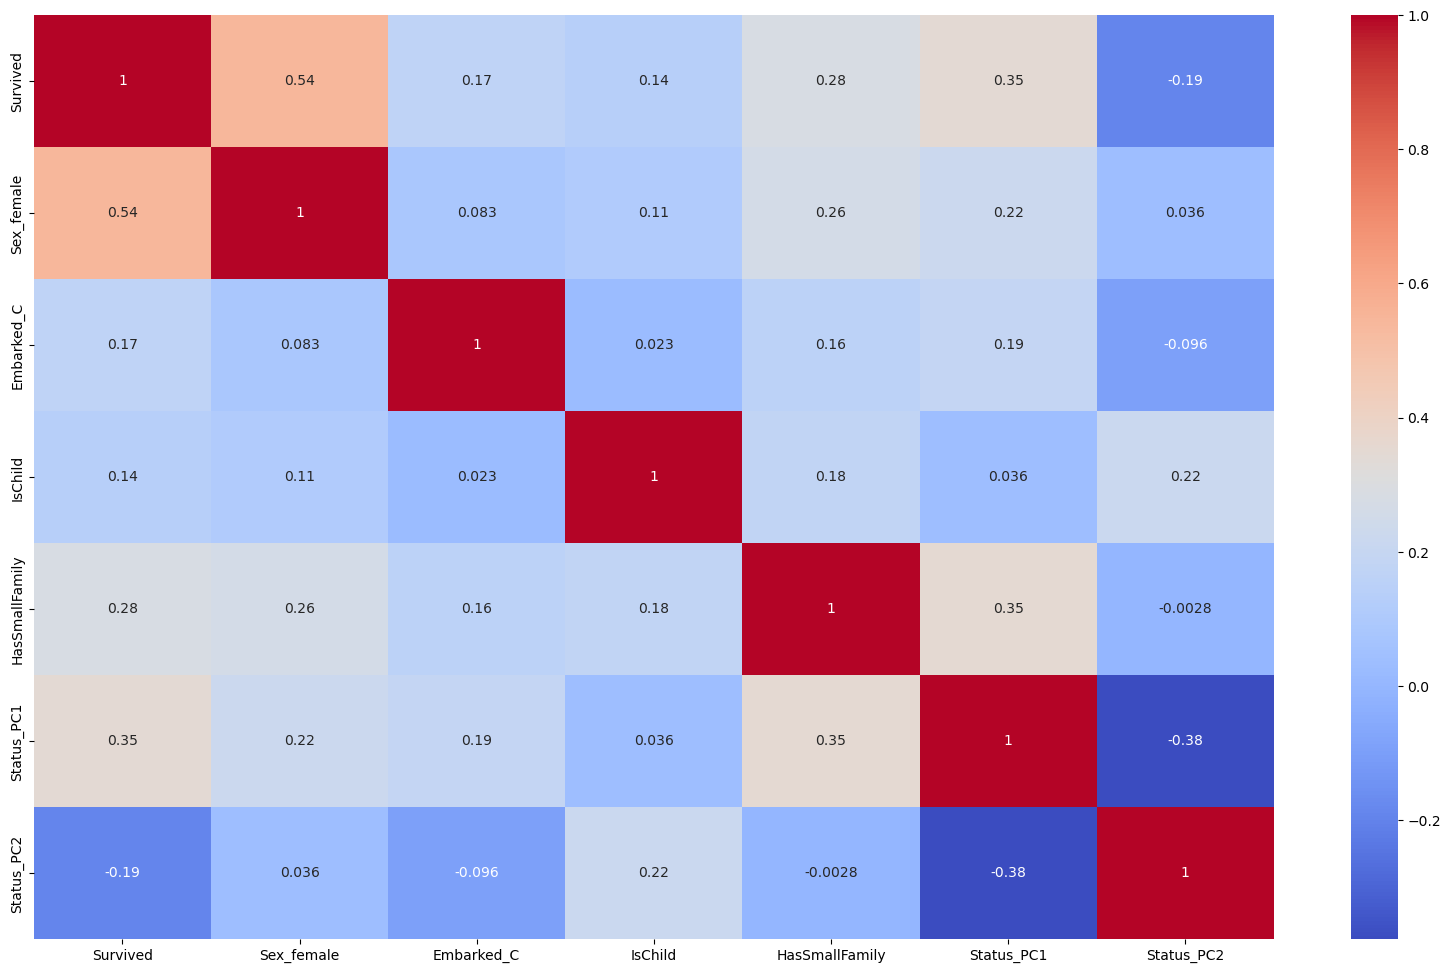

In [1443]:
df = df.drop("Name", "Ticket", "Cabin", "PassengerId")

df.head()
df.write_csv("../Data/Titanic/advancedDataframe.csv")
heatmap(df)